In [1]:
using Plots
using FFTW
using DSP
using StatsPlots
using StatsBase
using Statistics
using Turing

# Laser Stimulation Feature

This notebook will attempt to visualise the fluctuation of O2 and LFP readings after laser stimulation has occurred.

## Data Importing

In [2]:
include("../helpers/importing.jl")
lfp = import_lfp("Exp 2/R7/2022-05-11_17-39-17/Record Node 113/")
o2 = import_o2("Exp 2/R7/o2 r7.txt")

Dict{String, Vector{Float32}} with 4 entries:
  "laser"      => [328293.0, 450314.0, 495567.0, 535427.0, 627203.0, 731830.0, …
  "sync"       => [30452.0, 40944.0, 51395.0, 61876.0, 72372.0, 82849.0, 93294.…
  "data"       => [-269.721, -269.721, -269.721, -269.721, -269.721, -269.721, …
  "timestamps" => [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  1.5976f…

## Extracting Envelope of LFP Data

In [3]:
# Compute the Fourier Transform
sampling_rate = 1000
freqs = fftfreq(length(lfp["data"][1,:]), sampling_rate)

# Butterworth's low pass filter equation
function butterworth_low(freq, pass_freq, n=5)
    return 1 / (1 + (abs(freq) / pass_freq) ^ 2n)
end

# Butterworth's high pass filter equation
function butterworth_high(freq, pass_freq, n=5)
    return 1 / (1 + (pass_freq / abs(freq)) ^ 2n)
end


# Apply the Band-Pass Butterworth filter
band = [1, 45]
lfp_envelopes = []
for i in 1:length(lfp["data"][:,1])
    F = fft(lfp["data"][i, :])
    for i in 1:length(F)
        F[i] = F[i] * butterworth_high(freqs[i], band[1]) * butterworth_low(freqs[i], band[2]) 
    end
    banded_lfp = real(ifft(F))
    push!(lfp_envelopes, abs.(hilbert(banded_lfp)))
end
lfp_envelopes

4-element Vector{Any}:
 Float32[0.32467264, 0.3369137, 0.34916317, 0.36133584, 0.37329996, 0.38487384, 0.39582816, 0.40589353, 0.4147755, 0.42217076  …  0.20723967, 0.2182314, 0.22951834, 0.24102773, 0.25270066, 0.26449305, 0.27637628, 0.28833723, 0.3003736, 0.31248626]
 Float32[0.49513575, 0.52582496, 0.5550777, 0.58230066, 0.60692, 0.62839276, 0.6462165, 0.65994716, 0.669209, 0.67371005  …  0.23544918, 0.2503873, 0.2686107, 0.29001296, 0.3143275, 0.34116834, 0.37006277, 0.4004825, 0.43186152, 0.46361288]
 Float32[0.19749568, 0.21455085, 0.23110318, 0.24689661, 0.26168612, 0.27524698, 0.28738058, 0.29792053, 0.30673748, 0.31374452  …  0.055105843, 0.06351372, 0.073792115, 0.085748576, 0.099168174, 0.11382689, 0.12949821, 0.14594753, 0.1629325, 0.18020171]
 Float32[0.04994625, 0.04945567, 0.057460155, 0.07289393, 0.093339995, 0.1170033, 0.14275755, 0.16983, 0.19761258, 0.22557646  …  0.098879606, 0.10024655, 0.100168236, 0.09849456, 0.095118366, 0.08999296, 0.08316825, 0.074859396, 0.0

## Band-Pass Filtering O2 Data

In [4]:
# Compute the Fourier Transform
sampling_rate = 1000
F = fft(o2["data"])
freqs = fftfreq(length(o2["data"]), sampling_rate)

band_pass_F = copy(F)
for i in 1:length(band_pass_F)
    band_pass_F[i] = band_pass_F[i] * butterworth_high(freqs[i], band[1], 5) * butterworth_low(freqs[i], band[2], 5)
end

banded_o2 = real(ifft(band_pass_F))

1597615-element Vector{Float32}:
  0.49391225
  0.5759197
  0.65408814
  0.7261298
  0.7901367
  0.8446827
  0.8888846
  0.92242074
  0.94550717
  0.958839
  ⋮
 -0.040919203
 -0.017872652
  0.015638491
  0.059826728
  0.11436706
  0.17837344
  0.25041714
  0.32858807
  0.41059664

## Visualising Laser Stimulation Effect

### Single Event Effect

This section will plot the effect after a single laser event has occurred

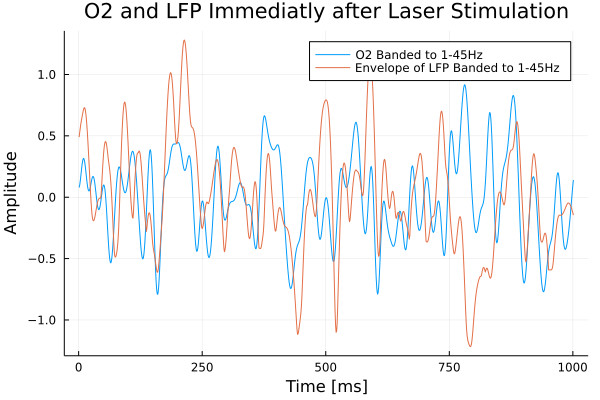

In [5]:
laser_flag = 1

o2_start = findall(x->x==o2["laser"][laser_flag], o2["timestamps"])[1]
lfp_start = findall(x->x==lfp["laser"]["on"][laser_flag], lfp["timestamps"])[1]
increment = 1000

lfp_channels_mean = zeros(increment+1)
for i in 1:length(lfp["data"][:,1])
    lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_start:lfp_start+increment])
end
lfp_channels_mean ./= length(lfp["data"][:,1])

plot(banded_o2[o2_start:o2_start+increment], label="O2 Banded to 1-45Hz")
plot!(lfp_channels_mean, label="Envelope of LFP Banded to 1-45Hz")

title!("O2 and LFP Immediatly after Laser Stimulation")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [6]:
for i in 1:length(lfp["data"][:,1])
    core = cor(banded_o2[o2_start:o2_start+increment], lfp_envelopes[i][lfp_start:lfp_start+increment])
    println("Channel $(i) correlation is: $(core)")
end
println(cor(banded_o2[o2_start:o2_start+increment], lfp_channels_mean))

Channel 1 correlation is: 0.31863838
Channel 2 correlation is: 0.059795544
Channel 3 correlation is: 0.07120583
Channel 4 correlation is: -0.064554535
0.2112890071110175


This first laser event shows a very promising correlation between the two datasets. Now lets plot the correlation value for each laser event.

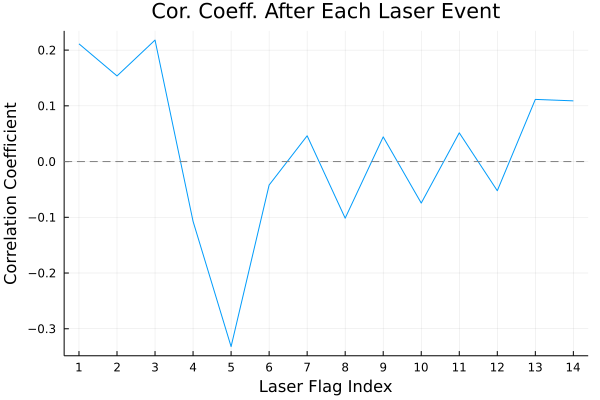

In [7]:
increment = 1000
cors = []

for flag in 1:length(o2["laser"])
    o2_start = findall(x->x==o2["laser"][flag], o2["timestamps"])[1]
    lfp_start = findall(x->x==lfp["laser"]["on"][flag], lfp["timestamps"])[1]

    lfp_channels_mean = zeros(increment+1)

    for i in 1:length(lfp["data"][:,1])
        lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_start:lfp_start+increment])
    end
    lfp_channels_mean ./= length(lfp["data"][:,1])

    push!(cors, cor(banded_o2[o2_start:o2_start+increment], lfp_channels_mean))
end

plot(cors, legend=false)
title!("Cor. Coeff. After Each Laser Event")
xlabel!("Laser Flag Index")
hline!([0], linestyle=:dash, colour=:grey)
xticks!((1:length(o2["laser"])))
ylabel!("Correlation Coefficient")


### All Events Averaged

This section will average the data immediately after each event and plot the result.

In [8]:
o2_starts = findall(x->x in o2["laser"], o2["timestamps"])[1:13]
lfp_starts = findall(x->x in lfp["laser"]["on"], lfp["timestamps"])[1:13]
increment = 1000

o2_subset_mean = zeros(increment+1)
lfp_subset_mean = zeros(increment+1)

for i in o2_starts
    o2_subset_mean += standardize(ZScoreTransform, banded_o2[i:i+increment])
end

for i in 1:4
    for j in lfp_starts
        lfp_subset_mean += standardize(ZScoreTransform, lfp_envelopes[i][j:j+increment])
    end
end

o2_subset_mean ./= length(o2_starts)
lfp_subset_mean ./= length(lfp_starts)
lfp_subset_mean ./= 4

1001-element Vector{Float64}:
  0.35241371615288347
  0.32740533860543597
  0.30058157358032006
  0.27180469709520155
  0.24128036483978996
  0.2108872474099581
  0.1844809296934937
  0.16252010344312742
  0.1435080079648357
  0.1251993622057713
  ⋮
 -0.032972859523187466
 -0.038439722946630075
 -0.047819733512229644
 -0.060453932732343674
 -0.07501848285587934
 -0.0903638661480867
 -0.10658544721081853
 -0.12378215435175942
 -0.1425086126770251

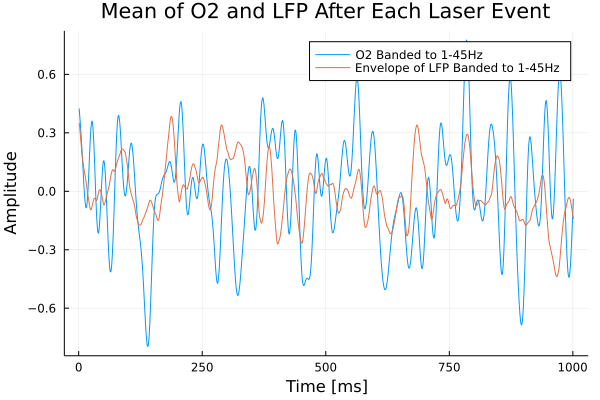

In [9]:
plot(o2_subset_mean, label="O2 Banded to 1-45Hz")
plot!(lfp_subset_mean, label="Envelope of LFP Banded to 1-45Hz")

title!("Mean of O2 and LFP After Each Laser Event")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [10]:
cor(o2_subset_mean, lfp_subset_mean)

0.05926483417426485

There is still some correlation after the laser events have been averaged. However, it is far weaker than the first data point.

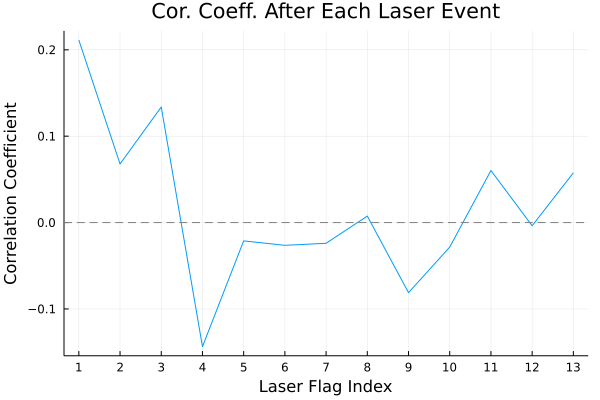

In [11]:
laser_flag = 1

o2_start = findall(x->x==o2["laser"][laser_flag], o2["timestamps"])[1]
lfp_starts = findall(x->x in lfp["laser"]["on"], lfp["timestamps"])[1:13]
increments = lfp_starts .- lfp_starts[1]
increment = 1000
cors = []

for flag in 1:13
    lfp_channels_mean = zeros(increment+1)

    for i in 1:4
        lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_starts[flag]:lfp_starts[flag]+increment])
    end
    lfp_channels_mean ./= 4

    push!(cors, cor(banded_o2[o2_start+increments[flag]:o2_start+increments[flag]+increment], lfp_channels_mean))
end

plot(cors, legend=false)
title!("Cor. Coeff. After Each Laser Event")
xlabel!("Laser Flag Index")
hline!([0], linestyle=:dash, colour=:grey)
xticks!((1:length(o2["laser"])))
ylabel!("Correlation Coefficient")

## Modelling the First Laser Flag

As there is a clear correlation between the O2 and LFP data at the first laser flag, it will be possible to make a model. The aim of this section if to create an AR model for the purpose of practising modelling and finding a basic relationship.

$$y_i \sim Normal(\mu_i, \sigma_i)$$

$$\mu_i = \sum_{j=1}^{10}\beta_jx_{i-j}$$

$$\beta_j \sim Normal(0, \tau_\beta)$$

$$\tau_\beta \sim Gamma(2, 2)$$

$$\sigma_i \sim Gamma(2, 2)$$

In [224]:
laser_flag = 1
o2_start = findall(x->x==o2["laser"][laser_flag], o2["timestamps"])[1]
lfp_start = findall(x->x==lfp["laser"]["on"][laser_flag], lfp["timestamps"])[1]
increment = 1000

lfp_channels_mean = zeros(increment+1)
for i in 1:4
    lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_start:lfp_start+increment])
end
lfp_channels_mean ./= 4

o2_subset = banded_o2[o2_start:o2_start+increment]
lfp_subset = lfp_channels_mean

1001-element Vector{Float64}:
  0.4899011328816414
  0.5220309123396873
  0.5546724111773074
  0.5846203006803989
  0.6108266115188599
  0.6338864713907242
  0.6554106175899506
  0.676846120506525
  0.6979244044050574
  0.7161064222455025
  ⋮
 -0.05224202573299408
 -0.058475375175476074
 -0.0664324015378952
 -0.0758172869682312
 -0.08664044737815857
 -0.09906992316246033
 -0.1132107675075531
 -0.12895983457565308
 -0.14596743881702423

In [225]:
@model function AR(y, x)
    # Priors
    tau_beta ~ Gamma(2, 2)
    beta ~ filldist(Normal(0, 1), 10)
    sigma ~ Gamma(2, 2)

    for i in 10:length(y)
        mu = sum(x[i-9:i] .* beta .* tau_beta)
        y[i] ~ Normal(mu, sigma)
    end
end

DynamicPPL.ModelGen{var"###generator#1386", (:y, :x), (), Tuple{}}(var"##generator#1386", NamedTuple())

In [227]:
# Define a moving average
lfp_moving_avg = []
for i in 10:length(lfp_subset)
    push!(lfp_moving_avg, mean(lfp_subset[i-9:i]))
end

In [226]:
@model function ARMA(y, x, xhat)
    # Priors
    tau_beta ~ Gamma(2, 2)
    beta ~ filldist(Normal(0, 1), 10)
    tau_alpha ~ Gamma(2, 2)
    alpha ~ Normal(0, 1)
    sigma ~ Gamma(2, 2)

    for i in 10:length(y)
        mu = sum(x[i-9:i] .* beta .* tau_beta) + xhat[i-9] * alpha * tau_alpha
        y[i] ~ Normal(mu, sigma)
    end
end

DynamicPPL.ModelGen{var"###generator#1414", (:y, :x, :xhat), (), Tuple{}}(var"##generator#1414", NamedTuple())

In [228]:
model = ARMA(o2_subset, lfp_subset, lfp_moving_avg)
chain = sample(model, NUTS(0.65), 1000)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/alex/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling   0%|                                          |  ETA: N/A
Sampling   0%|                                          |  ETA: 0:14:36
Sampling   0%|▏                                         |  ETA: 0:12:04
Sampling   0%|▏                                         |  ETA: 0:08:08
Sampling   0%|▏                                         |  ETA: 0:06:30
Sampling   0%|▎                                         |  ETA: 0:05:17
Sampling   1%|▎                                         |  ETA: 0:04:26
Sampling   1%|▎                                         |  ETA: 0:04:20
Sampling   1%|▍                                         |  ETA: 0:04:40
Sampling   1%|▍                                         |  ETA: 0:07:13
Sampling   1%|▍                                         |  ETA: 0:06:32
Sampling   1%|▌                                         |  ETA: 0:10:55
Samplin


Sampling  12%|████▉                                     |  ETA: 0:28:24
Sampling  12%|████▉                                     |  ETA: 0:28:21
Sampling  12%|█████                                     |  ETA: 0:28:07
Sampling  12%|█████                                     |  ETA: 0:28:42
Sampling  12%|█████                                     |  ETA: 0:28:33
Sampling  12%|█████▏                                    |  ETA: 0:28:24
Sampling  12%|█████▏                                    |  ETA: 0:28:08
Sampling  12%|█████▏                                    |  ETA: 0:28:17
Sampling  12%|█████▎                                    |  ETA: 0:28:03
Sampling  12%|█████▎                                    |  ETA: 0:27:57
Sampling  13%|█████▎                                    |  ETA: 0:28:30
Sampling  13%|█████▍                                    |  ETA: 0:28:27
Sampling  13%|█████▍                                    |  ETA: 0:28:12
Sampling  13%|█████▍                                    |  ETA:


Sampling  22%|█████████▍                                |  ETA: 0:27:55
Sampling  22%|█████████▍                                |  ETA: 0:27:45
Sampling  22%|█████████▍                                |  ETA: 0:27:49
Sampling  22%|█████████▌                                |  ETA: 0:27:45
Sampling  23%|█████████▌                                |  ETA: 0:27:36
Sampling  23%|█████████▌                                |  ETA: 0:27:38
Sampling  23%|█████████▋                                |  ETA: 0:27:35
Sampling  23%|█████████▋                                |  ETA: 0:27:38
Sampling  23%|█████████▋                                |  ETA: 0:27:29
Sampling  23%|█████████▊                                |  ETA: 0:27:42
Sampling  23%|█████████▊                                |  ETA: 0:27:43
Sampling  23%|█████████▊                                |  ETA: 0:27:36
Sampling  23%|█████████▉                                |  ETA: 0:27:27
Sampling  24%|█████████▉                                |  ETA:


Sampling  32%|█████████████▌                            |  ETA: 0:20:58
Sampling  32%|█████████████▌                            |  ETA: 0:20:52
Sampling  32%|█████████████▌                            |  ETA: 0:20:54
Sampling  32%|█████████████▋                            |  ETA: 0:20:52
Sampling  32%|█████████████▋                            |  ETA: 0:21:00
Sampling  32%|█████████████▋                            |  ETA: 0:20:58
Sampling  33%|█████████████▊                            |  ETA: 0:20:54
Sampling  33%|█████████████▊                            |  ETA: 0:20:49
Sampling  33%|█████████████▊                            |  ETA: 0:20:44
Sampling  33%|█████████████▉                            |  ETA: 0:20:39
Sampling  33%|█████████████▉                            |  ETA: 0:20:35
Sampling  33%|█████████████▉                            |  ETA: 0:20:29
Sampling  33%|██████████████                            |  ETA: 0:20:28
Sampling  33%|██████████████                            |  ETA:


Sampling  41%|█████████████████▎                        |  ETA: 0:16:50
Sampling  41%|█████████████████▎                        |  ETA: 0:16:48
Sampling  41%|█████████████████▍                        |  ETA: 0:16:45
Sampling  41%|█████████████████▍                        |  ETA: 0:16:41
Sampling  42%|█████████████████▍                        |  ETA: 0:16:39
Sampling  42%|█████████████████▌                        |  ETA: 0:16:37
Sampling  42%|█████████████████▌                        |  ETA: 0:16:36
Sampling  42%|█████████████████▌                        |  ETA: 0:16:34
Sampling  42%|█████████████████▋                        |  ETA: 0:16:30
Sampling  42%|█████████████████▋                        |  ETA: 0:16:30
Sampling  42%|█████████████████▋                        |  ETA: 0:16:29
Sampling  42%|█████████████████▊                        |  ETA: 0:16:26
Sampling  42%|█████████████████▊                        |  ETA: 0:16:23
Sampling  42%|█████████████████▊                        |  ETA:


Sampling  50%|████████████████████▉                     |  ETA: 0:14:29
Sampling  50%|████████████████████▉                     |  ETA: 0:14:32
Sampling  50%|████████████████████▉                     |  ETA: 0:14:32
Sampling  50%|█████████████████████                     |  ETA: 0:14:29
Sampling  50%|█████████████████████                     |  ETA: 0:14:27
Sampling  50%|█████████████████████                     |  ETA: 0:14:25
Sampling  50%|█████████████████████▏                    |  ETA: 0:14:23
Sampling  50%|█████████████████████▏                    |  ETA: 0:14:21
Sampling  50%|█████████████████████▏                    |  ETA: 0:14:19
Sampling  50%|█████████████████████▎                    |  ETA: 0:14:17
Sampling  51%|█████████████████████▎                    |  ETA: 0:14:15
Sampling  51%|█████████████████████▎                    |  ETA: 0:14:13
Sampling  51%|█████████████████████▍                    |  ETA: 0:14:11
Sampling  51%|█████████████████████▍                    |  ETA:

Excessive output truncated after 524298 bytes.


Sampling  58%|████████████████████████▎                 |  ETA: 0:11:58
Sampling  58%|████████████████████████▎                 |  ETA: 0:11:57
Sampling  58%|████████████████████████▍                 |  ETA: 0:11:55
Sampling  58%|████████████████████████▍                 |  ETA: 0:11:53
Sampling  58%|████████████████████████▍                 |  ETA: 0:11:51
Sampling  58%|████████████████████████▌                 |  ETA: 0:11:49
Sampling  58%|████████████████████████▌                 |  ETA: 0:11:46
Sampling  58%|████████████████████████▌                 |  ETA: 0:11:45
Sampling  58%|████████████████████████▋                 |  ETA: 0:11:43
Sampling  59%|████████████████████████▋                 |  ETA: 0:11:43
Sampling  59%|████████████████████████▋                 |  ETA: 0:11:41
Sampling  59%|████████████████████████▊                 |  ETA: 0:11:39
Sampling  59%|████████████████████████▊                 |  ETA: 0:11:38
Sampling  59%|████████████████████████▊                 |  ETA:

Object of type Chains, with data of type 500×26×1 Array{Float64, 3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = alpha, beta[1], beta[2], beta[3], beta[4], beta[5], beta[6], beta[7], beta[8], beta[9], beta[10], sigma, tau_alpha, tau_beta

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters     mean     std  naive_se    mcse       ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ────────  ──────
       alpha  -0.0510  0.5970    0.0267  0.0897   51.2497  1.0386
     beta[1]  -0.2822  0.5998    0.0268  0.0773   79.5711  1.0333
     beta[2]  -0.0710  0.8059    0.0360  0.0283  112.7706  1.0081
     beta[3]   0.3505  0.8785    0.0393  0.1390   25.0813  1.0229
     beta[4]   0.0366  0.8467    0.037

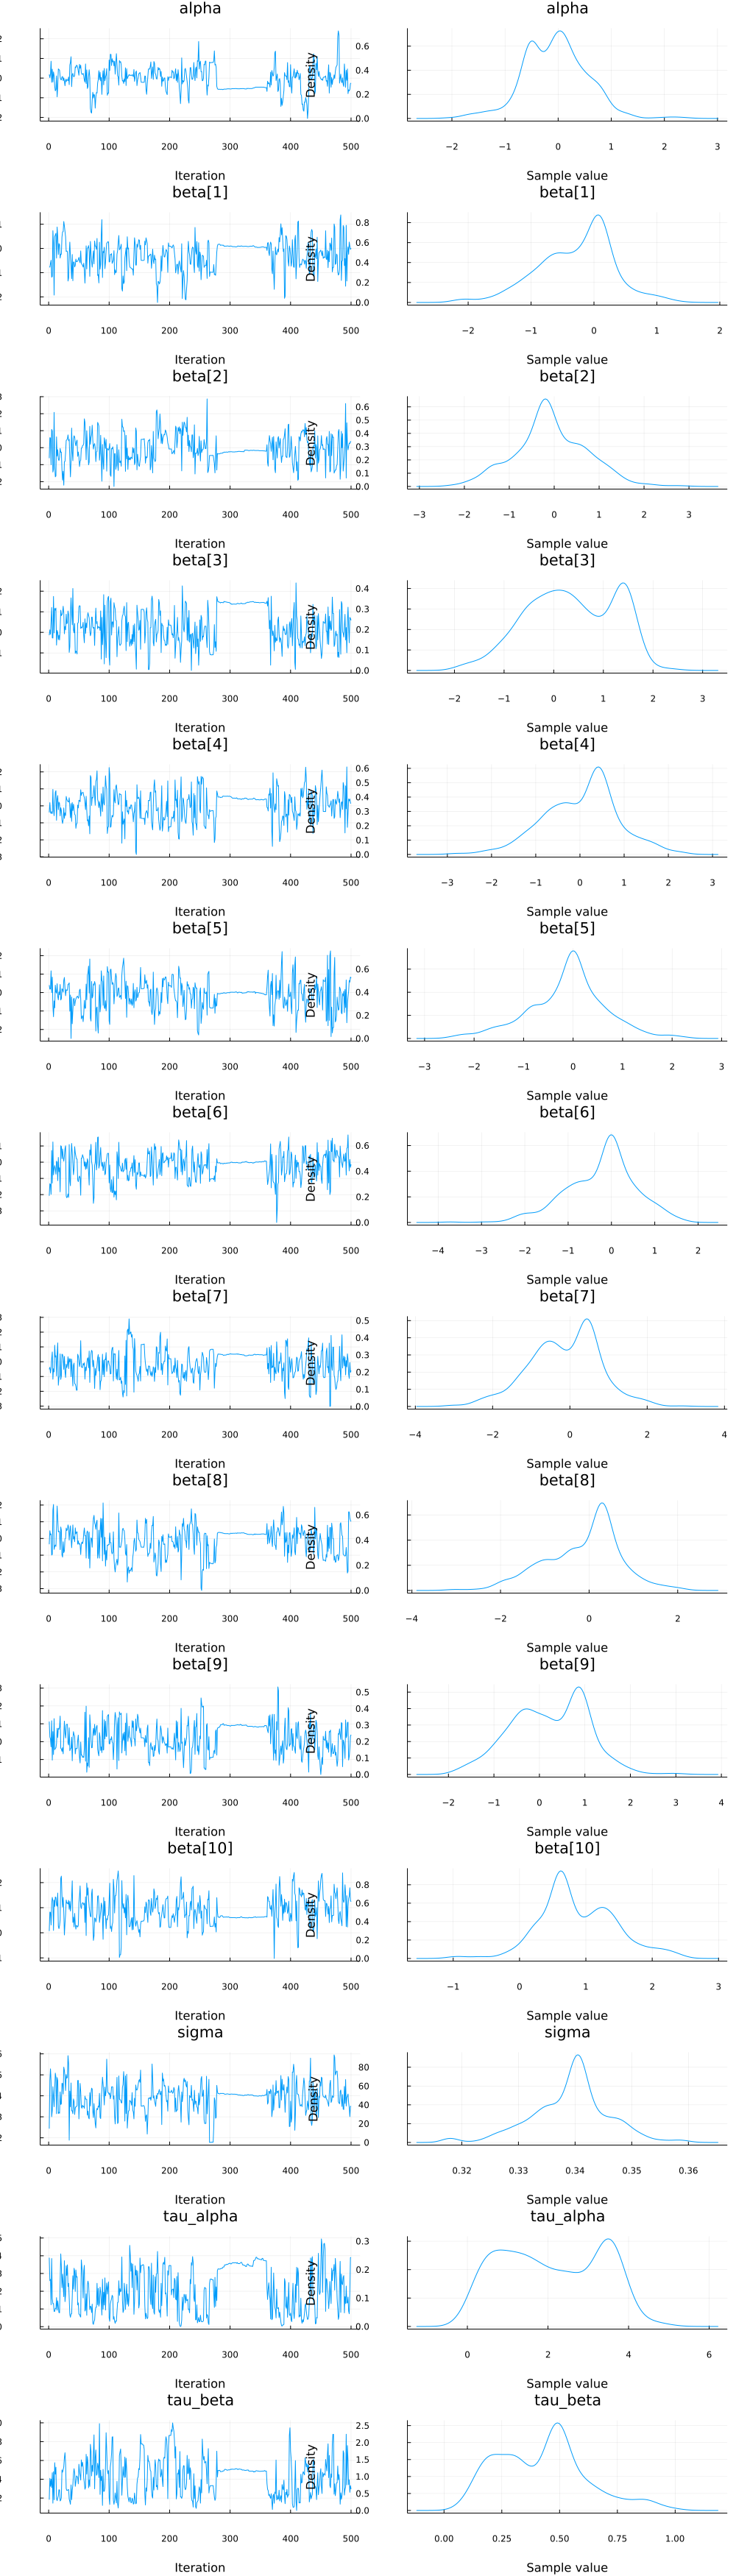

In [229]:
plot(chain)

In [232]:
length(chain)
parms = chain.name_map.parameters

using Random, Distributions
Random.seed!(123) # Setting the seed

function posteriorSample(chain)
    parms = chain.name_map.parameters
    idx = rand(1:length(chain))
    return map(x->chain[x].value[idx] , parms)
end

postSample = [posteriorSample(chain) for i in 1:1000]

predictions = []
for i in 10:length(lfp_subset)
    pred_i = []
    for sample in postSample
        mu = sum(lfp_subset[i-9:i] .* sample[1:10] .* sample[12])
        post = rand(Normal(mu, sample[11]), 1)
        push!(pred_i, post[1])
    end
    push!(predictions, pred_i)
end

ArgumentError: ArgumentError: Normal: the condition σ >= zero(σ) is not satisfied.

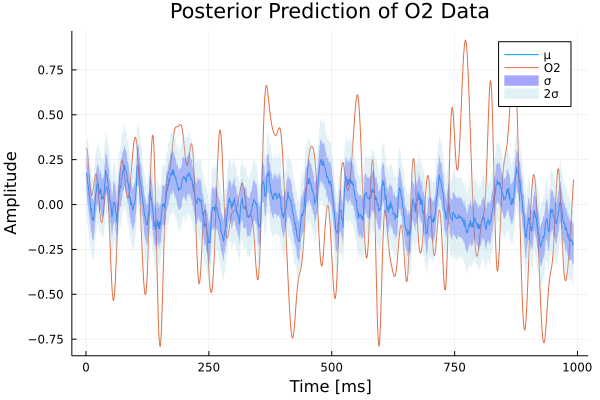

In [151]:
means = [mean(predictions[i]) for i in 1:length(predictions)]
vars = [var(predictions[i]) for i in 1:length(predictions)]

plot(means, label="μ")
plot!(o2_subset[10:end], label="O2")
plot!(means.-vars, fillrange=means.+vars, fillalpha = 0.35, linealpha=0, c="Blue", label="σ")
plot!(means.-(2*vars), fillrange=means.+(2*vars), fillalpha = 0.35, linealpha=0, c="Light Blue", label="2σ")

title!("Posterior Prediction of O2 Data")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [148]:
cor(means, o2_subset[10:end])

0.3001232045410527

The model above does a fairly good job of predicting O2 considering that there was not a large correlation to LFP. However, there does seem to be some sort of undesirable smoothing effect. Also the posteriors look quite large which signals that there needs to be more data or stronger priors. It is visible in the chain that there is a region between samples 270-360 where is autocorrelation happening, the sampler should be run longer and/or with more chains to mitigate this effect. 

### Addressing Multicollinearity

The issue with the model above is that there will be an auto correlation between $x_{i-10}$ to $x_i$ this will cause multicollinearity between all values of $\beta$ making their actual values arbitrary. This can be fixed by modifying the model.

$$y_i \sim Normal(\mu_i, \sigma_i)$$

$$\mu_i = \beta\sum_{j=1}^{10}x_{i-j}$$

$$\beta \sim Normal(0, \tau_\beta)$$

$$\tau_\beta \sim Gamma(2, 2)$$

$$\sigma_i \sim Gamma(2, 2)$$

In [167]:
@model function AR_no_multi_colin(y, x)
    # Priors
    tau_beta ~ Gamma(2, 2)
    beta ~ Normal(0, 1)
    sigma ~ Gamma(2, 2)

    for i in 10:length(y)
        mu = sum(x[i-9:i]) * .beta * .tau_beta
        y[i] ~ Normal(mu, sigma)
    end
end

DynamicPPL.ModelGen{var"###generator#1168", (:y, :x), (), Tuple{}}(var"##generator#1168", NamedTuple())

In [168]:
model = AR_no_multi_colin(o2_subset, lfp_subset)
chain = sample(model, NUTS(0.65), 1000)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/alex/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling   0%|                                          |  ETA: N/A
Sampling   0%|                                          |  ETA: 0:13:03
Sampling   0%|▏                                         |  ETA: 0:08:00
Sampling   0%|▏                                         |  ETA: 0:05:21
Sampling   0%|▏                                         |  ETA: 0:04:03
Sampling   0%|▎                                         |  ETA: 0:03:15
Sampling   1%|▎                                         |  ETA: 0:02:43
Sampling   1%|▎                                         |  ETA: 0:02:20
Sampling   1%|▍                                         |  ETA: 0:02:04
Sampling   1%|▍                                         |  ETA: 0:01:51
Sampling   1%|▍                                         |  ETA: 0:01:42
Sampling   1%|▌                                         |  ETA: 0:01:33
Samplin


Sampling  12%|████▉                                     |  ETA: 0:00:55
Sampling  12%|████▉                                     |  ETA: 0:00:55
Sampling  12%|█████                                     |  ETA: 0:00:55
Sampling  12%|█████                                     |  ETA: 0:00:55
Sampling  12%|█████                                     |  ETA: 0:00:55
Sampling  12%|█████▏                                    |  ETA: 0:00:54
Sampling  12%|█████▏                                    |  ETA: 0:00:55
Sampling  12%|█████▏                                    |  ETA: 0:00:54
Sampling  12%|█████▎                                    |  ETA: 0:00:54
Sampling  12%|█████▎                                    |  ETA: 0:00:54
Sampling  13%|█████▎                                    |  ETA: 0:00:54
Sampling  13%|█████▍                                    |  ETA: 0:00:53
Sampling  13%|█████▍                                    |  ETA: 0:00:53
Sampling  13%|█████▍                                    |  ETA:


Sampling  22%|█████████▍                                |  ETA: 0:00:47
Sampling  22%|█████████▍                                |  ETA: 0:00:47
Sampling  22%|█████████▍                                |  ETA: 0:00:46
Sampling  22%|█████████▌                                |  ETA: 0:00:46
Sampling  23%|█████████▌                                |  ETA: 0:00:46
Sampling  23%|█████████▌                                |  ETA: 0:00:46
Sampling  23%|█████████▋                                |  ETA: 0:00:46
Sampling  23%|█████████▋                                |  ETA: 0:00:46
Sampling  23%|█████████▋                                |  ETA: 0:00:46
Sampling  23%|█████████▊                                |  ETA: 0:00:45
Sampling  23%|█████████▊                                |  ETA: 0:00:45
Sampling  23%|█████████▊                                |  ETA: 0:00:45
Sampling  23%|█████████▉                                |  ETA: 0:00:45
Sampling  24%|█████████▉                                |  ETA:


Sampling  32%|█████████████▌                            |  ETA: 0:00:39
Sampling  32%|█████████████▌                            |  ETA: 0:00:39
Sampling  32%|█████████████▌                            |  ETA: 0:00:39
Sampling  32%|█████████████▋                            |  ETA: 0:00:38
Sampling  32%|█████████████▋                            |  ETA: 0:00:38
Sampling  32%|█████████████▋                            |  ETA: 0:00:38
Sampling  33%|█████████████▊                            |  ETA: 0:00:38
Sampling  33%|█████████████▊                            |  ETA: 0:00:38
Sampling  33%|█████████████▊                            |  ETA: 0:00:38
Sampling  33%|█████████████▉                            |  ETA: 0:00:38
Sampling  33%|█████████████▉                            |  ETA: 0:00:38
Sampling  33%|█████████████▉                            |  ETA: 0:00:38
Sampling  33%|██████████████                            |  ETA: 0:00:37
Sampling  33%|██████████████                            |  ETA:


Sampling  41%|█████████████████▎                        |  ETA: 0:00:33
Sampling  41%|█████████████████▎                        |  ETA: 0:00:32
Sampling  41%|█████████████████▍                        |  ETA: 0:00:32
Sampling  41%|█████████████████▍                        |  ETA: 0:00:32
Sampling  42%|█████████████████▍                        |  ETA: 0:00:32
Sampling  42%|█████████████████▌                        |  ETA: 0:00:33
Sampling  42%|█████████████████▌                        |  ETA: 0:00:32
Sampling  42%|█████████████████▌                        |  ETA: 0:00:32
Sampling  42%|█████████████████▋                        |  ETA: 0:00:32
Sampling  42%|█████████████████▋                        |  ETA: 0:00:32
Sampling  42%|█████████████████▋                        |  ETA: 0:00:32
Sampling  42%|█████████████████▊                        |  ETA: 0:00:32
Sampling  42%|█████████████████▊                        |  ETA: 0:00:32
Sampling  42%|█████████████████▊                        |  ETA:


Sampling  50%|████████████████████▉                     |  ETA: 0:00:27
Sampling  50%|████████████████████▉                     |  ETA: 0:00:27
Sampling  50%|████████████████████▉                     |  ETA: 0:00:27
Sampling  50%|█████████████████████                     |  ETA: 0:00:26
Sampling  50%|█████████████████████                     |  ETA: 0:00:26
Sampling  50%|█████████████████████                     |  ETA: 0:00:26
Sampling  50%|█████████████████████▏                    |  ETA: 0:00:26
Sampling  50%|█████████████████████▏                    |  ETA: 0:00:26
Sampling  50%|█████████████████████▏                    |  ETA: 0:00:26
Sampling  50%|█████████████████████▎                    |  ETA: 0:00:26
Sampling  51%|█████████████████████▎                    |  ETA: 0:00:26
Sampling  51%|█████████████████████▎                    |  ETA: 0:00:26
Sampling  51%|█████████████████████▍                    |  ETA: 0:00:26
Sampling  51%|█████████████████████▍                    |  ETA:


Sampling  58%|████████████████████████▎                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▎                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▍                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▍                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▍                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▌                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▌                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▌                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▋                 |  ETA: 0:00:21
Sampling  59%|████████████████████████▋                 |  ETA: 0:00:21
Sampling  59%|████████████████████████▋                 |  ETA: 0:00:21
Sampling  59%|████████████████████████▊                 |  ETA: 0:00:21
Sampling  59%|████████████████████████▊                 |  ETA: 0:00:20
Sampling  59%|████████████████████████▊                 |  ETA:


Sampling  65%|███████████████████████████▌              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▌              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▌              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▋              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▋              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▋              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▊              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▊              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▊              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▉              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▉              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▉              |  ETA: 0:00:16
Sampling  67%|████████████████████████████              |  ETA: 0:00:16
Sampling  67%|████████████████████████████              |  ETA:


Sampling  73%|██████████████████████████████▌           |  ETA: 0:00:13
Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:13
Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:13
Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:12
Sampling  73%|██████████████████████████████▊           |  ETA: 0:00:12
Sampling  73%|██████████████████████████████▊           |  ETA: 0:00:12
Sampling  73%|██████████████████████████████▊           |  ETA: 0:00:12
Sampling  73%|██████████████████████████████▉           |  ETA: 0:00:12
Sampling  74%|██████████████████████████████▉           |  ETA: 0:00:12
Sampling  74%|██████████████████████████████▉           |  ETA: 0:00:12
Sampling  74%|███████████████████████████████           |  ETA: 0:00:12
Sampling  74%|███████████████████████████████           |  ETA: 0:00:12
Sampling  74%|███████████████████████████████           |  ETA: 0:00:12
Sampling  74%|███████████████████████████████▏          |  ETA:


Sampling  80%|█████████████████████████████████▌        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▌        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▌        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▊        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▊        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▊        |  ETA: 0:00:09
Sampling  81%|█████████████████████████████████▉        |  ETA: 0:00:09
Sampling  81%|█████████████████████████████████▉        |  ETA: 0:00:09
Sampling  81%|█████████████████████████████████▉        |  ETA: 0:00:09
Sampling  81%|██████████████████████████████████        |  ETA: 0:00:09
Sampling  81%|██████████████████████████████████        |  ETA:


Sampling  86%|████████████████████████████████████▍     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▍     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▍     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▋     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▋     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▋     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▊     |  ETA: 0:00:06
Sampling  88%|████████████████████████████████████▊     |  ETA: 0:00:06
Sampling  88%|████████████████████████████████████▊     |  ETA: 0:00:06
Sampling  88%|████████████████████████████████████▉     |  ETA: 0:00:05
Sampling  88%|████████████████████████████████████▉     |  ETA:


Sampling  93%|███████████████████████████████████████   |  ETA: 0:00:03
Sampling  93%|███████████████████████████████████████▏  |  ETA: 0:00:03
Sampling  93%|███████████████████████████████████████▏  |  ETA: 0:00:03
Sampling  93%|███████████████████████████████████████▏  |  ETA: 0:00:03
Sampling  93%|███████████████████████████████████████▎  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▎  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▎  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▍  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▍  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:02
Sampling  94%|███████████████████████████████████████▋  |  ETA: 0:00:02
Sampling  94%|███████████████████████████████████████▋  |  ETA:


Sampling  99%|█████████████████████████████████████████▊|  ETA: 0:00:00
Sampling  99%|█████████████████████████████████████████▊|  ETA: 0:00:00
Sampling 100%|█████████████████████████████████████████▊|  ETA: 0:00:00
Sampling 100%|█████████████████████████████████████████▉|  ETA: 0:00:00
Sampling 100%|█████████████████████████████████████████▉|  ETA: 0:00:00
Sampling 100%|█████████████████████████████████████████▉|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████| Time: 0:00:42
Sampling 100%|██████████████████████████████████████████| Time: 0:00:42


Object of type Chains, with data of type 500×15×1 Array{Float64, 3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = beta, sigma, tau_beta

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters    mean     std  naive_se    mcse      ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ───────  ──────
        beta  0.2806  0.2194    0.0098  0.0263  38.7434  1.0279
       sigma  0.3364  0.0074    0.0003  0.0010  47.3411  0.9985
    tau_beta  1.0533  0.6344    0.0284  0.1044  20.7556  1.0291

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
        beta  0.0808  0.1189  0.2016  0.3771  0.7993
       sigma  0.3230  0.3312  0.3356  0.3414  0

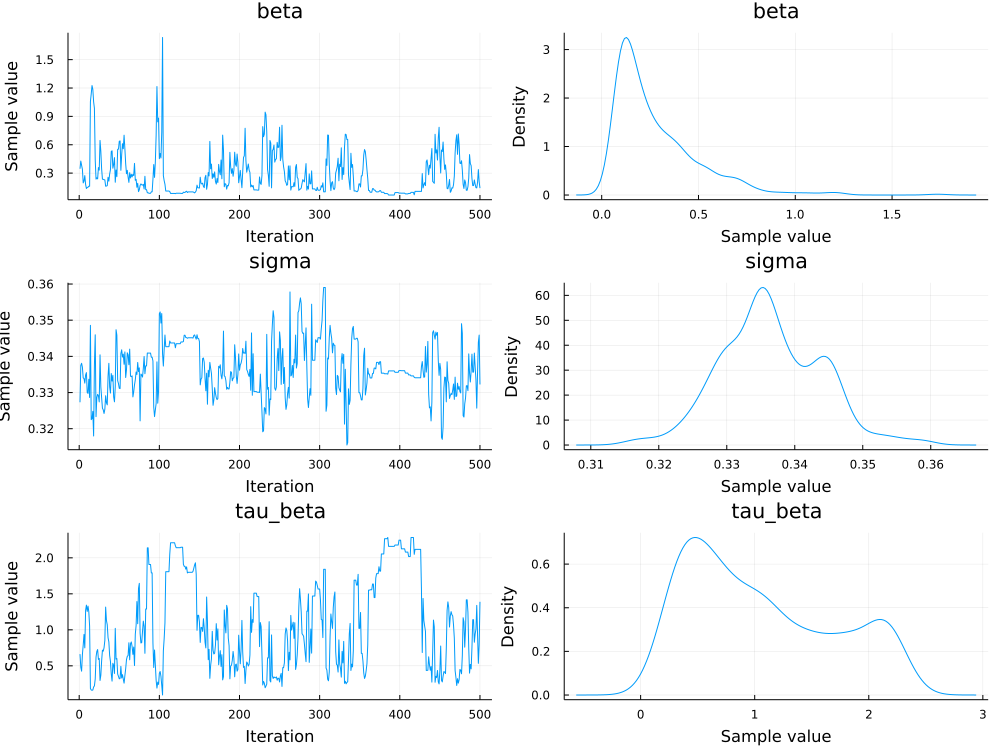

In [169]:
plot(chain)

In [172]:
length(chain)
parms = chain.name_map.parameters

using Random, Distributions
Random.seed!(123) # Setting the seed

function posteriorSample(chain)
    parms = chain.name_map.parameters
    idx = rand(1:length(chain))
    return map(x->chain[x].value[idx] , parms)
end

postSample = [posteriorSample(chain) for i in 1:1000]

predictions = []
for i in 10:length(lfp_subset)
    pred_i = []
    for sample in postSample
        mu = sum(lfp_subset[i-9:i]) * sample[1] * sample[3]
        post = rand(Normal(mu, sample[2]), 1)
        push!(pred_i, post[1])
    end
    push!(predictions, pred_i)
end

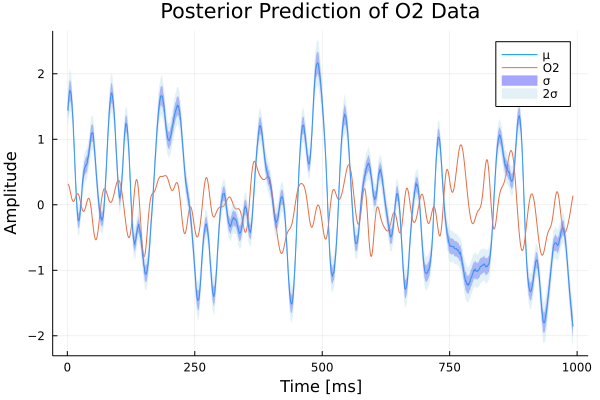

In [173]:
means = [mean(predictions[i]) for i in 1:length(predictions)]
vars = [var(predictions[i]) for i in 1:length(predictions)]

plot(means, label="μ")
plot!(o2_subset[10:end], label="O2")
plot!(means.-vars, fillrange=means.+vars, fillalpha=0.35, linealpha=0, c="Blue", label="σ")
plot!(means.-(2*vars), fillrange=means.+(2*vars), fillalpha=0.35, linealpha=0, c="Light Blue", label="2σ")

title!("Posterior Prediction of O2 Data")
xlabel!("Time [ms]")
ylabel!("Amplitude")